In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn import metrics, preprocessing, model_selection
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

pd.options.display.max_columns = 100

/Users/srk/envs/DS2/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_df = pd.read_csv("../input/train_cm.csv")
test_df = pd.read_csv("../input/test_cm.csv")
print(train_df.shape, test_df.shape)

(341424, 24) (146765, 23)


In [3]:
train_df.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,05/04/18,05/04/18,06/04/18,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,23/01/15,11/04/15,16/04/15,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,28/01/15,01/02/15,05/02/15,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,02/05/15,11/06/15,16/06/15,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,02/09/15,14/12/15,19/12/15,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


In [4]:
train_df["state_code_resort"].value_counts()

1     59830
2     55883
6     50869
7     37809
3     33489
5     32784
9     28115
11    18271
4     14820
10     5684
13     3870
Name: state_code_resort, dtype: int64

In [5]:
date_cols = ["booking_date", "checkin_date", "checkout_date"]
for date_col in date_cols:
    train_df[date_col] = pd.to_datetime(train_df[date_col], format="%d/%m/%y")
    test_df[date_col] = pd.to_datetime(test_df[date_col], format="%d/%m/%y")
    
    train_df[date_col + "_day"] = train_df[date_col].dt.day
    test_df[date_col + "_day"] = test_df[date_col].dt.day
    
    train_df[date_col + "_month"] = train_df[date_col].dt.month
    test_df[date_col + "_month"] = test_df[date_col].dt.month
    
    train_df[date_col + "_year"] = train_df[date_col].dt.year
    test_df[date_col + "_year"] = test_df[date_col].dt.year
    
    train_df[date_col + "_weekday"] = train_df[date_col].dt.weekday
    test_df[date_col + "_weekday"] = test_df[date_col].dt.weekday
    
    train_df[date_col + "_week"] = train_df[date_col].dt.week
    test_df[date_col + "_week"] = test_df[date_col].dt.week
    
train_df["days_stay"] = (train_df["checkout_date"] - train_df["checkin_date"]).dt.days
test_df["days_stay"] = (test_df["checkout_date"] - test_df["checkin_date"]).dt.days

train_df["days_advance_booking"] = (train_df["checkin_date"] - train_df["booking_date"]).dt.days
test_df["days_advance_booking"] = (test_df["checkin_date"] - test_df["booking_date"]).dt.days

In [6]:
for col in train_df.columns:
    if train_df[col].dtype==object and col not in ["reservation_id", "amount_spent_per_room_night_scaled"]:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

member_age_buckets
memberid
cluster_code
reservationstatusid_code
resort_id


In [7]:
for col1, col2 in [
                   ["roomnights", "days_stay"],
                   
                  ]:
    train_df[col1+"_ratio_"+col2] = train_df[col1] / train_df[col2]
    test_df[col1+"_ratio_"+col2] = test_df[col1] / test_df[col2]

In [8]:
for col in [
            "memberid", ["resort_id", "checkin_date"],
            ["resort_id", "checkout_date"],
            ["state_code_residence", "checkin_date"],
            ["memberid", "checkin_date_year"],
            ["memberid", "checkin_date_month"],
            ["resort_id", "checkin_date_year"],
            ["resort_id", "checkin_date_month"],
            ["resort_id", "checkin_date_year", "checkin_date_month"],
    
            ["resort_id", "state_code_residence", "checkin_date"],
            ["resort_id", "state_code_residence", "checkout_date"],
    
            ["resort_id", "checkin_date_year", "checkin_date_week"],
            ["resort_id", "state_code_residence", "checkin_date_year", "checkin_date_week"],
            ["resort_id", "state_code_residence", "checkin_date_year", "checkin_date_month"],
    
    
            ["booking_date", "checkin_date"],
            ["booking_date", "checkin_date", "resort_id"],
    

           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train_df[["reservation_id"]+ col], test_df[["reservation_id"]+ col]])
    gdf = all_df.groupby(col)["reservation_id"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")

In [10]:
feat_df = pd.read_csv("feat_v2.csv")
train_df = pd.merge(train_df, feat_df, on="reservation_id", how="left")
test_df = pd.merge(test_df, feat_df, on="reservation_id", how="left")
del feat_df

In [13]:
cols_to_exclude = ["reservation_id", "amount_spent_per_room_night_scaled", "memberid"]+date_cols
cols_to_use = [col for col in train_df.columns if col not in cols_to_exclude]
train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df["amount_spent_per_room_night_scaled"].values
print(train_X.shape, test_X.shape)

(341424, 142) (146765, 142)


In [14]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=50, rounds=20000):
    params = {}
    params["objective"] = "regression"
    params['metric'] = 'rmse'
    params["max_depth"] = dep
    params["num_leaves"] = 30
    params["min_data_in_leaf"] = data_leaf
#     params["min_sum_hessian_in_leaf"] = 50
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.2
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 1
    params["bagging_seed"] = seed
    params["lambda_l2"] = 3
    params["lambda_l1"] = 3
    params["verbosity"] = -1
    num_rounds = rounds

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
    #imps = model.feature_importance()
    #names = model.feature_name()
    #for fi, fn in enumerate(names):
    #    print(fn, imps[fi])

    loss = 0
    if test_y is not None:
        loss = np.sqrt(metrics.mean_squared_error(test_y, pred_test_y))
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [15]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 5
#kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
gkf = model_selection.GroupKFold(n_splits=n_splits)
model_name = "lgb"
for dev_index, val_index in gkf.split(train_X, train_df["amount_spent_per_room_night_scaled"].values, train_df["memberid"].values):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=6, data_leaf=200, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=7, data_leaf=180, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
#     model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=7, data_leaf=200, seed=4568)
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1
    
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = np.sqrt(metrics.mean_squared_error(val_y, pred_val))
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
    print(cv_scores)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's rmse: 0.977279
[1000]	valid_0's rmse: 0.967515
[1500]	valid_0's rmse: 0.965278
[2000]	valid_0's rmse: 0.964368
[2500]	valid_0's rmse: 0.963803
[3000]	valid_0's rmse: 0.963413
[3500]	valid_0's rmse: 0.963152
[4000]	valid_0's rmse: 0.96296
[4500]	valid_0's rmse: 0.962868
[5000]	valid_0's rmse: 0.962808
[5500]	valid_0's rmse: 0.962781
Early stopping, best iteration is:
[5471]	valid_0's rmse: 0.96277
0.9627700256055174
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's rmse: 0.97737
[1000]	valid_0's rmse: 0.96735
[1500]	valid_0's rmse: 0.96513
[2000]	valid_0's rmse: 0.964184
[2500]	valid_0's rmse: 0.963628
[3000]	valid_0's rmse: 0.963246
[3500]	valid_0's rmse: 0.963024
[4000]	valid_0's rmse: 0.962878
[4500]	valid_0's rmse: 0.962832
Early stopping, best iteration is:
[4795]	valid_0's rmse: 0.962742
0.9627415867114623
[0.9626281565005608]
Training until validation score

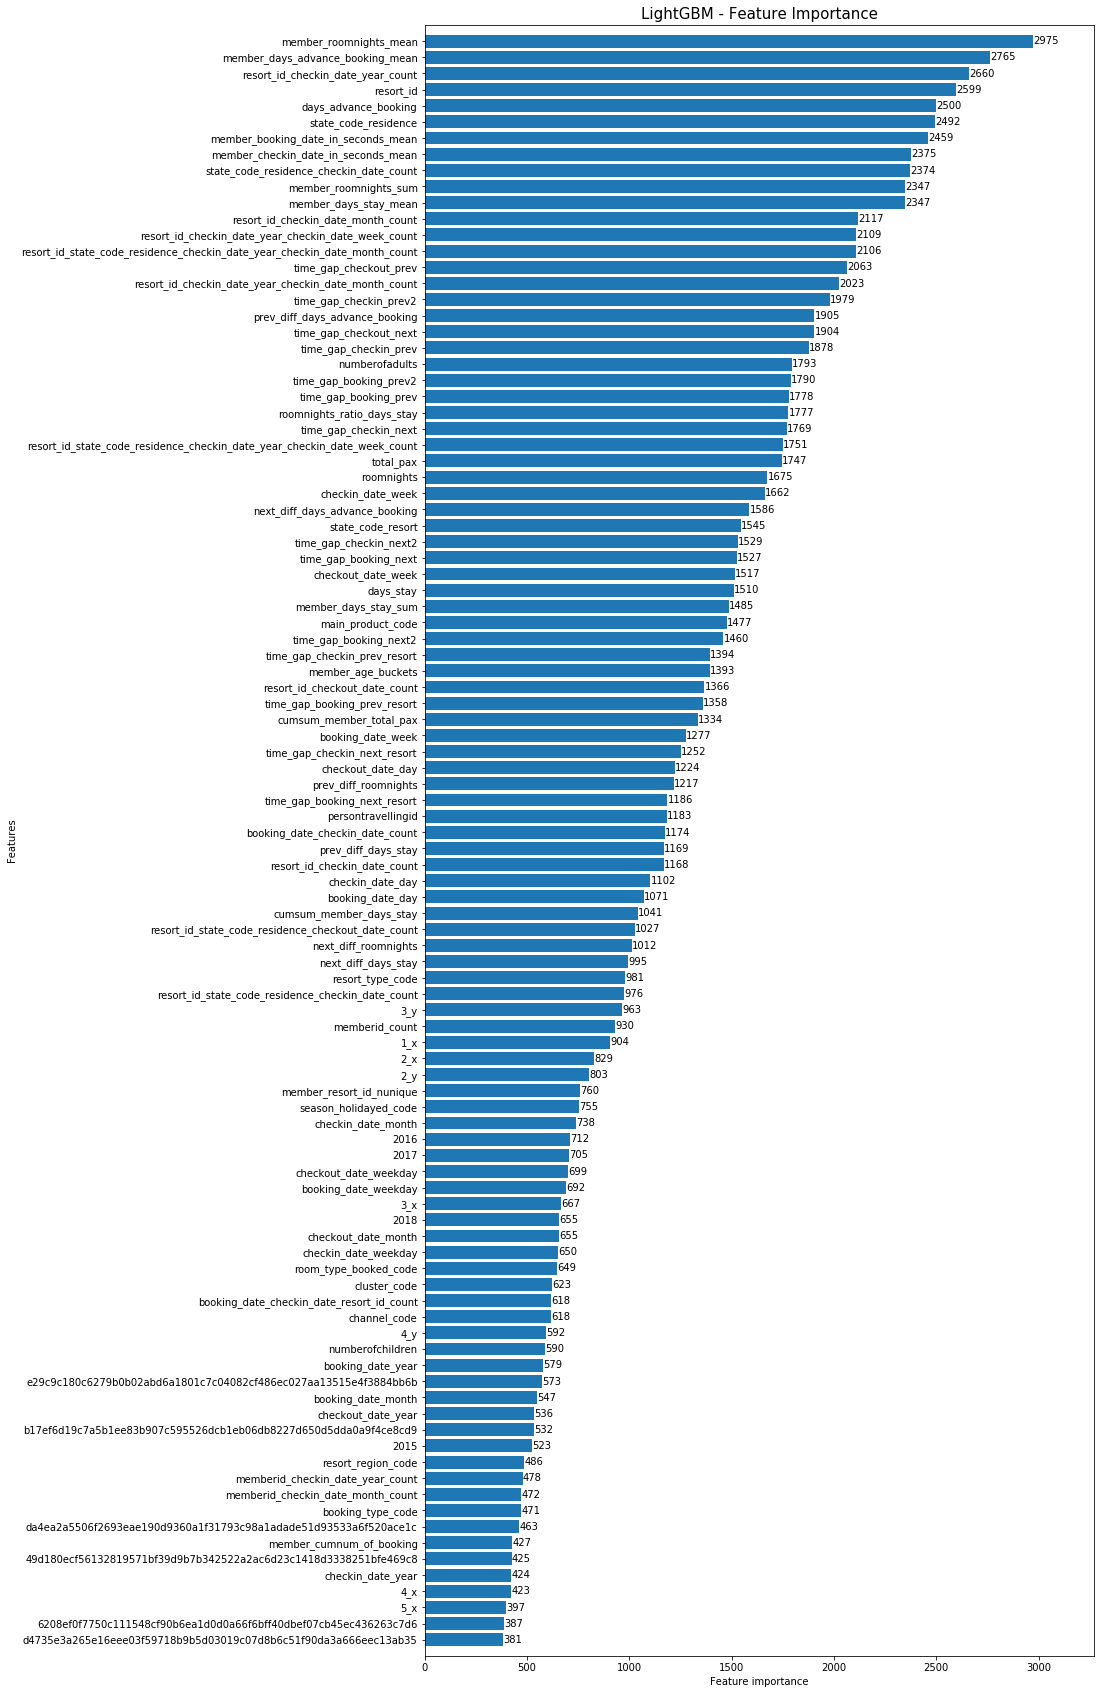

In [16]:
fig, ax = plt.subplots(figsize=(12,30))
lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [17]:
sub_df = pd.DataFrame(test_df[["reservation_id"]])
sub_df["amount_spent_per_room_night_scaled"] = pred_test_full
sub_df.to_csv("sub10.csv", index=False)